<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
#!kaggle datasets download -d erhmrai/ecg-image-data
!kaggle datasets download -d mohamedeldakrory8/ecg-heart-categorization-dataset-image-version

 96% 468M/486M [00:06<00:00, 110MB/s] 
100% 486M/486M [00:06<00:00, 81.9MB/s]


In [4]:
'''import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-image-data.zip','r')
zip_ref.extractall('/content')
zip_ref.close()'''
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-heart-categorization-dataset-image-version.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
!rm /content/ECG-data/train/F/*
!rmdir /content/ECG-data/train/F

In [7]:
!rm /content/ECG-data/test/F/*
!rmdir /content/ECG-data/test/F

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob

In [9]:
train_dir = Path('/content/ECG-data/train')
test_dir = Path('/content/ECG-data/test')

In [10]:
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG-data/train/Q/2005.jpg,Q
1,/content/ECG-data/train/Q/1629.jpg,Q
2,/content/ECG-data/train/Q/5682.jpg,Q
3,/content/ECG-data/train/Q/2051.jpg,Q
4,/content/ECG-data/train/Q/5225.jpg,Q
...,...,...
97131,/content/ECG-data/train/V/4916.jpg,V
97132,/content/ECG-data/train/V/3260.jpg,V
97133,/content/ECG-data/train/V/2847.jpg,V
97134,/content/ECG-data/train/V/2303.jpg,V


In [11]:
dataframe['Label'].value_counts()

N             72471
M              8000
Q              6431
V              5788
S              2223
F-resample     2223
Name: Label, dtype: int64

In [12]:
train_samples = []
for category in ['N','M','Q','V','S','F-resample']:
    train_category = dataframe.query("Label == @category")
    train_samples.append(train_category.sample(2000, random_state=1))

dataframe_train = pd.concat(train_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

V             2000
F-resample    2000
N             2000
M             2000
S             2000
Q             2000
Name: Label, dtype: int64

In [13]:
dataframe_train

,Filepath,Label
0,/content/ECG-data/train/V/3569.jpg,V
1,/content/ECG-data/train/F-resample/1622.jpg,F-resample
2,/content/ECG-data/train/N/29216.jpg,N
3,/content/ECG-data/train/M/2520.jpg,M
4,/content/ECG-data/train/F-resample/1928.jpg,F-resample
...,...,...
11995,/content/ECG-data/train/V/2316.jpg,V
11996,/content/ECG-data/train/F-resample/829.jpg,F-resample
11997,/content/ECG-data/train/N/51653.jpg,N
11998,/content/ECG-data/train/Q/1363.jpg,Q


In [14]:
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,/content/ECG-data/test/Q/1181.jpg,Q
1,/content/ECG-data/test/Q/1193.jpg,Q
2,/content/ECG-data/test/Q/897.jpg,Q
3,/content/ECG-data/test/Q/314.jpg,Q
4,/content/ECG-data/test/Q/756.jpg,Q
...,...,...
24787,/content/ECG-data/test/V/450.jpg,V
24788,/content/ECG-data/test/V/865.jpg,V
24789,/content/ECG-data/test/V/246.jpg,V
24790,/content/ECG-data/test/V/916.jpg,V


In [15]:
dataframe_test['Label'].value_counts()

N              18118
M               2506
Q               1608
V               1448
S                556
F-resampled      556
Name: Label, dtype: int64

In [16]:
test_samples = []
for category in ['N','M','Q','V','S','F-resampled']:
    test_category = dataframe_test.query("Label == @category")
    test_samples.append(test_category.sample(500, random_state=1))

dataframe_test = pd.concat(test_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

V              500
S              500
Q              500
N              500
F-resampled    500
M              500
Name: Label, dtype: int64

In [17]:
dataframe_test

,Filepath,Label
0,/content/ECG-data/test/V/770.jpg,V
1,/content/ECG-data/test/S/115.jpg,S
2,/content/ECG-data/test/Q/1380.jpg,Q
3,/content/ECG-data/test/V/178.jpg,V
4,/content/ECG-data/test/Q/1223.jpg,Q
...,...,...
2995,/content/ECG-data/test/F-resampled/123.jpg,F-resampled
2996,/content/ECG-data/test/M/958.jpg,M
2997,/content/ECG-data/test/Q/488.jpg,Q
2998,/content/ECG-data/test/N/833.jpg,N


In [20]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    shear_range = 0.2,
    horizontal_flip=True,
    zoom_range = 0.2,
    validation_split=0.3
  
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255
)

In [21]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 8400 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [22]:
test_generator.class_indices

{'F-resampled': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

In [23]:
folders=glob('/content/ECG-data/test/*')
folders

['/content/ECG-data/test/Q',
 '/content/ECG-data/test/M',
 '/content/ECG-data/test/S',
 '/content/ECG-data/test/F-resampled',
 '/content/ECG-data/test/N',
 '/content/ECG-data/test/V']

In [24]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
for layer in vgg.layers:
  layer.trainable = False

In [26]:
x = Flatten()(vgg.output)

In [27]:
prediction = Dense(len(folders), activation='softmax')(x)

In [28]:
vgg_model = Model(inputs=vgg.input, outputs=prediction)

vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [30]:
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
result=vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20
263/263 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.8123
Epoch 1: val_accuracy improved from 0.73500 to 0.82306, saving model to best_model.h5
263/263 [==============================] - 152s 576ms/step - loss: 0.5156 - accuracy: 0.8123 - val_loss: 0.5154 - val_accuracy: 0.8231
Epoch 2/20
263/263 [==============================] - ETA: 0s - loss: 0.4849 - accuracy: 0.8248
Epoch 2: val_accuracy did not improve from 0.82306
263/263 [==============================] - 151s 574ms/step - loss: 0.4849 - accuracy: 0.8248 - val_loss: 0.5283 - val_accuracy: 0.8133
Epoch 3/20
263/263 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.8418
Epoch 3: val_accuracy improved from 0.82306 to 0.84583, saving model to best_model.h5
263/263 [==============================] - 153s 582ms/step - loss: 0.4388 - accuracy: 0.8418 - val_loss: 0.4312 - val_accuracy: 0.8458
Epoch 4/20
263/263 [==============================] - ETA: 0s - loss: 0.4069 - accur

In [33]:
vgg_model.save('best.h5')

In [34]:
from keras.models import load_model
best_model1=load_model('/content/best.h5')
results1 = best_model1.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.37272
Test Accuracy: 88.07%


In [35]:
from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.36563
Test Accuracy: 88.97%


Text(0, 0.5, 'accuracy')

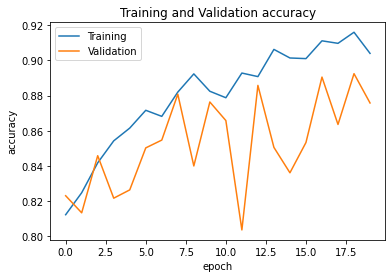

In [36]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [37]:
y_pred = best_model.predict(test_generator)
y_pred

94/94 [==============================] - 14s 146ms/step


array([[6.40873807e-08, 2.54522263e-07, 4.67902424e-07, 1.00169878e-03,
        1.35143084e-04, 9.98862386e-01],
       [4.37850346e-11, 2.21908817e-06, 1.32176376e-06, 3.60838526e-10,
        9.99989867e-01, 6.56260045e-06],
       [9.74293464e-15, 1.00854165e-10, 4.99127628e-09, 9.99995947e-01,
        8.72327710e-10, 4.07134394e-06],
       ...,
       [2.40601246e-12, 2.37914435e-07, 2.44263077e-07, 9.95343089e-01,
        3.66789870e-08, 4.65640472e-03],
       [7.92853029e-07, 4.66490120e-01, 5.01740575e-01, 5.84578572e-07,
        2.51039602e-02, 6.66393572e-03],
       [1.98780779e-08, 9.98844098e-06, 2.30639343e-05, 9.96095598e-01,
        9.85961960e-05, 3.77275073e-03]], dtype=float32)

In [38]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([5, 4, 3, ..., 3, 2, 3])

In [39]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[448   5   3   0  10  34]
 [  0 485   9   0   3   3]
 [  8  77 345   0  45  25]
 [  1   7   1 480   5   6]
 [  4  16  21   0 444  15]
 [ 14   6   1   2  10 467]]
classification report
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       500
           1       0.81      0.97      0.89       500
           2       0.91      0.69      0.78       500
           3       1.00      0.96      0.98       500
           4       0.86      0.89      0.87       500
           5       0.85      0.93      0.89       500

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



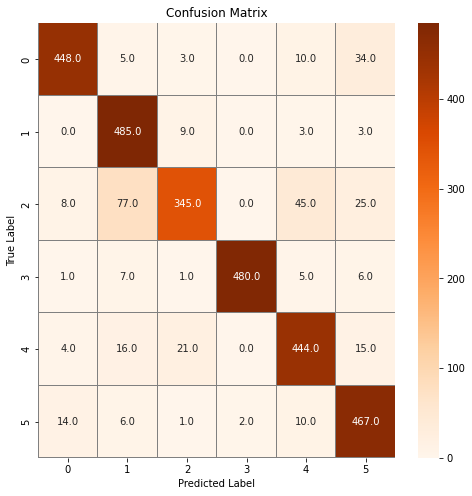

In [40]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [41]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'F-resample', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 1s 967ms/step


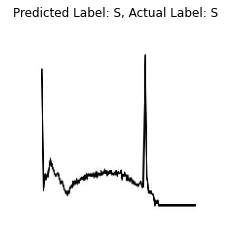

In [42]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG-data/train/S/1084.jpg'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model1.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='S')

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy

(288, 432, 4)


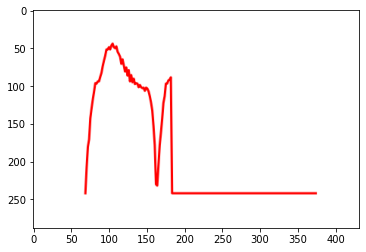

In [ ]:
import cv2
path =r'/content/ECG_Image_data/test/S/S1070.png'
x=plt.imread(path)
#x = cv2.imread(path)
print(x.shape)
plt.imshow(x)

In [ ]:
%%time
dir = Path('/content/ECG_Image_data/train')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

CPU times: user 1.32 s, sys: 110 ms, total: 1.43 s
Wall time: 1.43 s


,Filepath,Label
0,/content/ECG_Image_data/train/Q/Q7160.png,Q
1,/content/ECG_Image_data/train/Q/Q6290.png,Q
2,/content/ECG_Image_data/train/Q/Q4355.png,Q
3,/content/ECG_Image_data/train/Q/Q4205.png,Q
4,/content/ECG_Image_data/train/Q/Q4595.png,Q
...,...,...
99194,/content/ECG_Image_data/train/M/M2111.png,M
99195,/content/ECG_Image_data/train/M/M3229.png,M
99196,/content/ECG_Image_data/train/M/M7575.png,M
99197,/content/ECG_Image_data/train/M/M5756.png,M


In [ ]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [ ]:
samples = []
for category in dataframe['Label'].unique():
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

Q    640
S    640
N    640
M    640
V    640
F    640
Name: Label, dtype: int64

In [ ]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/Q/Q7777.png,Q
1,/content/ECG_Image_data/train/S/S2361.png,S
2,/content/ECG_Image_data/train/N/N23794.png,N
3,/content/ECG_Image_data/train/N/N11078.png,N
4,/content/ECG_Image_data/train/M/M9937.png,M
...,...,...
3835,/content/ECG_Image_data/train/N/N59233.png,N
3836,/content/ECG_Image_data/train/V/V2873.png,V
3837,/content/ECG_Image_data/train/V/V3412.png,V
3838,/content/ECG_Image_data/train/Q/Q718.png,Q


In [ ]:
%%time
dir = Path('/content/ECG_Image_data/test')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

CPU times: user 478 ms, sys: 16.2 ms, total: 494 ms
Wall time: 491 ms


,Filepath,Label
0,/content/ECG_Image_data/test/Q/Q4558.png,Q
1,/content/ECG_Image_data/test/Q/Q6909.png,Q
2,/content/ECG_Image_data/test/Q/Q2132.png,Q
3,/content/ECG_Image_data/test/Q/Q1658.png,Q
4,/content/ECG_Image_data/test/Q/Q872.png,Q
...,...,...
24794,/content/ECG_Image_data/test/M/M940.png,M
24795,/content/ECG_Image_data/test/M/M2063.png,M
24796,/content/ECG_Image_data/test/M/M644.png,M
24797,/content/ECG_Image_data/test/M/M1686.png,M


In [ ]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [ ]:

samples = []
for category in dataframe_test['Label'].unique():
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

V    160
M    160
S    160
Q    160
F    160
N    160
Name: Label, dtype: int64

In [ ]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/V/V6816.png,V
1,/content/ECG_Image_data/test/M/M1273.png,M
2,/content/ECG_Image_data/test/S/S1728.png,S
3,/content/ECG_Image_data/test/S/S1676.png,S
4,/content/ECG_Image_data/test/S/S2340.png,S
...,...,...
955,/content/ECG_Image_data/test/N/N46344.png,N
956,/content/ECG_Image_data/test/Q/Q5604.png,Q
957,/content/ECG_Image_data/test/M/M1337.png,M
958,/content/ECG_Image_data/test/V/V6156.png,V


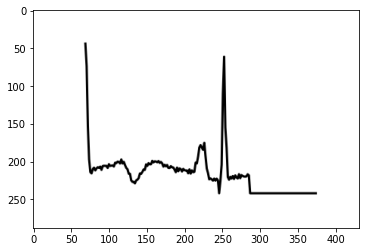

In [ ]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [ ]:
array_image = img_to_array(img)
print(array_image.shape)

(288, 432, 3)


In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                   shear_range = 0.2,
                   horizontal_flip=True,
                   zoom_range = 0.2,
                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        '/content/ECG_Image_data/train', 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        subset='training',
        class_mode= "categorical")
val_generator = train_datagen.flow_from_directory(
        '/content/ECG_Image_data/train', 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        subset='validation',
        class_mode= "categorical")
test_generator = test_datagen.flow_from_directory(
        '/content/ECG_Image_data/test', 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        class_mode= "categorical")

Found 79362 images belonging to 6 classes.
Found 19837 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print("data_batch shape --> ",data_batch.shape)
    print("labels_batch shape --> ",labels_batch.shape)
    break

data_batch shape -->  (32, 224, 224, 3)
labels_batch shape -->  (32, 6)


In [ ]:
test_generator.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

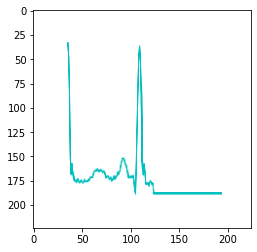

In [ ]:
plt.imshow(test_generator[0][0][3])

In [ ]:
from tensorflow import keras
KerasModel = keras.models.Sequential([#bulid nn
        keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)),
        #1 convolutional layer 200filter each filter 3*3 relu  input 100*100*3 rgb
        keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
         keras.layers.BatchNormalization(),
       #2 convolutional layer 150filter each filter 3*3 relu
        keras.layers.MaxPool2D(4,4),
        keras.layers.Dropout(rate=0.5) ,
        #3 maxpool layer 4*4
        keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),
        #4 convolutional layer 120filter each filter 3*3 relu
        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'), 
        keras.layers.BatchNormalization(),
        #5 convolutional layer 80filter each filter 3*3 relu
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        keras.layers.BatchNormalization(),
        #6 convolutional layer 50filter each filter 3*3 relu
        keras.layers.MaxPool2D(4,4),#7 maxpool layer 4*4
        keras.layers.Dropout(rate=0.5) ,

        keras.layers.Flatten(),  #make the matrix flate
        keras.layers.Dense(120,activation='relu') , #hidden layer (120cell)   
        keras.layers.Dense(100,activation='relu') , #hidden layer (100cell)
        keras.layers.Dense(50,activation='relu') ,  #hidden layer (50cell)      
        keras.layers.Dropout(rate=0.5) , 
        #drop some nuron 50% reduces the number of connections to increase speed and reduces the overfit
        keras.layers.Dense(6,activation='softmax') ,  #output layer 6  
    ])


KerasModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 200)     5600      
                                                                 
 conv2d_6 (Conv2D)           (None, 220, 220, 150)     270150    
                                                                 
 batch_normalization_3 (Batc  (None, 220, 220, 150)    600       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 55, 55, 150)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 55, 55, 150)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 53, 53, 120)      

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
# Compiling the CNN
KerasModel.compile(optimizer=Adam(learning_rate=0.001), loss =CategoricalCrossentropy(), metrics = ['accuracy'])

In [ ]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
'''result=model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[checkpoint]
)


hist = model.fit(
        train_generator ,
        steps_per_epoch=train_generator .samples//32, 
        validation_data=test_generator,
        validation_steps=test_generator .samples//32,
        epochs=15,
        callbacks=[checkpoint])'''

KerasModel.fit_generator(
                         train_generator ,
                         steps_per_epoch=train_generator .samples//32,#len(train_generator), 
                         validation_data=val_generator,
                         validation_steps=val_generator .samples//32,#len(val_generator),
                         epochs=15,
                         callbacks=[checkpoint]
                    )



<ipython-input-25-f04908360afa>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  KerasModel.fit_generator(


Epoch 1/15
 155/2480 [>.............................] - ETA: 20:57:48 - loss: 0.3949 - accuracy: 0.8867

KeyboardInterrupt: ignored